# Canny Edge Detection 
Canny edge detection is a multistage edge detection algorithm that takes grayscale images and was developed by John F. Canny [1] [2].

1) Gaussian blurring
2) Intensity gradients and direction
3) Non-maximum supression
4) Double tresholding and hysteresis edge tracking

The following steps and explenations are mainly based of [1] and [3]

In [26]:
#Imports
import matplotlib.pyplot as plt 
import importlib
import numpy as np
import cv2
from scipy.signal import convolve2d
from collections import deque

# Preprocessing:
Before applying the Canny edge detector, images need to be converted from BGR to grayscale.
Optionaly downscaling will also be an option for large images.

downscaling done
Downscaling done: 3072x4080 → 1536x2040


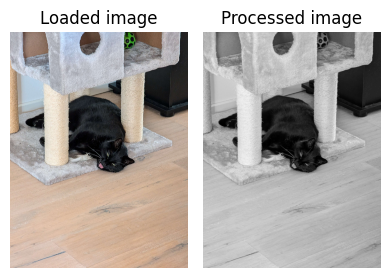

In [33]:
image_path = input("enter the path to the image you want to process: ")
imageBGR = cv2.imread(image_path)
imageRGB = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
processed_img = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY) 

if processed_img is None:
    raise ValueError("image not found")

downscale_to_50_percent = input("do you want to downscale the image to 50%? (y/n): ")
if downscale_to_50_percent.lower() == "y":
    height, width = processed_img.shape[:2]
    new_width = int(width * 0.5)
    new_height = int(height * 0.5)
    processed_img = cv2.resize(processed_img, (new_width, new_height), interpolation = cv2.INTER_AREA)
    print("downscaling done")
    print(f"Downscaling done: {width}x{height} → {new_width}x{new_height}")

#show original and preprocessed image
fig, (im1, im2) = plt.subplots(1, 2, figsize = (4, 3))

im1.imshow(imageRGB)
im1.set_title("Loaded image")
im1.axis("off")

im2.imshow(processed_img, cmap = "gray")
im2.set_title("Processed image")
im2.axis("off")

plt.tight_layout()
plt.show() 

# 1) Gaussian blurring is applied to reduce noise by using a gaussian filter

Here we will use open cv's GaussianBlur function. Define the kernel size and the stadard deviation in the x and y direction. 



Gaussian blurr applied


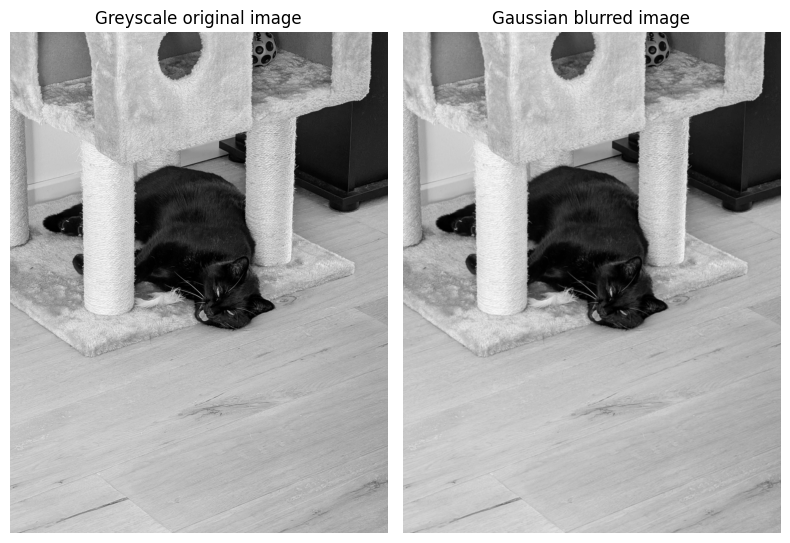

In [34]:
image_gaussian_blurred = cv2.GaussianBlur(processed_img, (5,5), 0)
print("Gaussian blurr applied")

fig, (im1, im2) = plt.subplots(1, 2, figsize = (8, 7))

im1.imshow(processed_img, cmap = "gray")
im1.set_title("Greyscale original image")
im1.axis("off")

im2.imshow(image_gaussian_blurred, cmap = "gray")
im2.set_title("Gaussian blurred image")
im2.axis("off")

plt.tight_layout()
plt.show() 

# 2) Intensity gradients and direction

Calculate the intensity gradient of the image. This is done with a Sobel kernel filter calculating the gradient of the image in the vertical and horizontal direction. It measures how the intensity changes in each of the directions. The magnitude of the directional gradient of each pixel can be found using: $$ G = \sqrt{G_x^2 + G_y^2} $$ And the corresponding direction using: $$ \theta = \arctan\left(\frac{G_y}{G_x}\right) $$

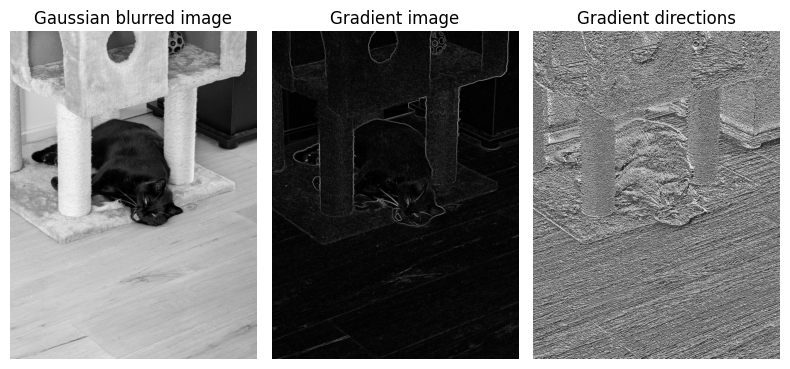

In [35]:
sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0], 
                    [1, 2, 1]])
sobel_x = sobel_y.T

#Convolce the entire image with the sobel filters:
Gx = convolve2d(image_gaussian_blurred, sobel_x, mode = "same", boundary = "symm")
Gy = convolve2d(image_gaussian_blurred, sobel_y, mode = "same", boundary = "symm")

#Compute the gradient magnitude and direction
G = np.sqrt(np.square(Gx) + np.square(Gy))
directions = np.arctan2(Gy, Gx)

fig, (im1, im2, im3) = plt.subplots(1, 3, figsize = (8, 7))
im1.imshow(image_gaussian_blurred, cmap = "gray")
im1.set_title("Gaussian blurred image")
im1.axis("off")

im2.imshow(G, cmap = "gray")
im2.set_title("Gradient image")
im2.axis("off")

im3.imshow(directions, cmap = "gray")
im3.set_title("Gradient directions")
im3.axis("off")

plt.tight_layout()
plt.show() 

# 3) Non-maximum Supression

Non-maximum Supression is used to remove pixels that aren't part of the edge, essentialy thining out the edges. It works by checking if a pixel "is a local maximum in its neighborhood in the direction of gradient" [1]. If so, the pixel is kept otherwhise it is set to zero. 

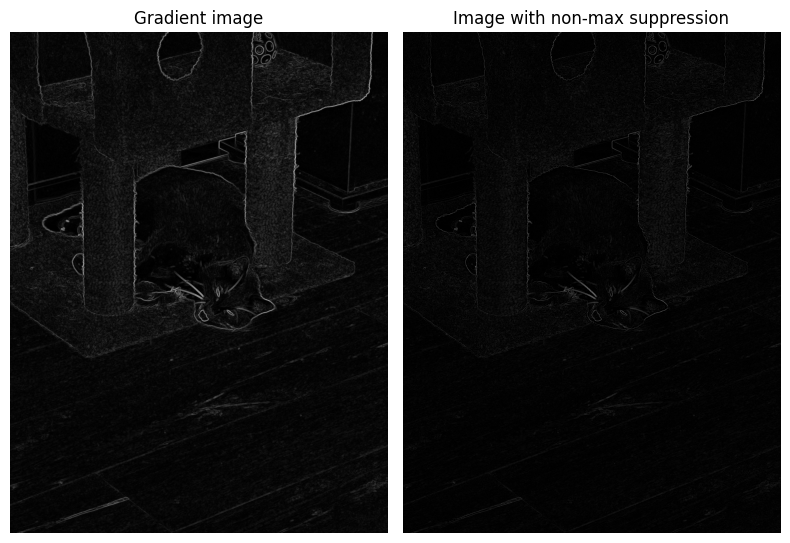

In [37]:
# Quantize the gradient directions from the directions matrix into 0, 45, 90, and 135 for this step

non_max_img = np.zeros_like(G) 
rows, cols = directions.shape
directions = np.mod(directions, np.pi) #Transfomr all angles into the 4 relevant directions eg: -45 -> 135 degrees

for i in range(1,rows-1): #avoid the very edge of the image for the computation
    for j in range(1, cols-1):
        # Direction 0 degrees:
        if abs(directions[i,j]) <= np.pi/8 or (abs(directions[i,j]) > 7 * np.pi/8):
            if G[i,j-1] <= G[i,j] >= G[i,j+1]:
                non_max_img[i,j] = G[i,j]
        # Direction 45 degrees:
        elif abs(directions[i,j]) <= 3 * np.pi/8 and (abs(directions[i,j]) > np.pi/8):
            if G[i-1,j-1] <= G[i,j] >= G[i+1,j+1]:
                non_max_img[i,j] = G[i,j]
        # Direction 90 degrees
        elif abs(directions[i,j]) > 3 * np.pi/8 and (abs(directions[i,j]) <= 5 * np.pi/8):
            if G[i-1,j] <= G[i,j] >= G[i+1,j]:
                non_max_img[i,j] = G[i,j]
        # Direction 135 degrees
        elif abs(directions[i,j]) <= 7 * np.pi/8 and (abs(directions[i,j]) > 5 * np.pi/8):
            if G[i-1,j+1] <= G[i,j] >= G[i+1,j-1]:
                non_max_img[i,j] = G[i,j]

fig, (im1, im2) = plt.subplots(1, 2, figsize = (8, 7))

im1.imshow(G, cmap = "gray")
im1.set_title("Gradient image")
im1.axis("off")

im2.imshow(non_max_img, cmap = "gray")
im2.set_title("Image with non-max suppression")
im2.axis("off")

plt.tight_layout()
plt.show() 


# 4) Double thresholding and hysteresis edge tracking

 To determine which edges in the picture after step 3 are actually edges, we apply double thresholding. We define two threshold values: one upper and one lower value. Pixels that are above the upper threshold are defined to be strong edges, and pixels that are below the threshold are completely discarded. Pixel values in between are defined to be weak edges, if they are connected to strong edges we keep them, otherwhise discard them.

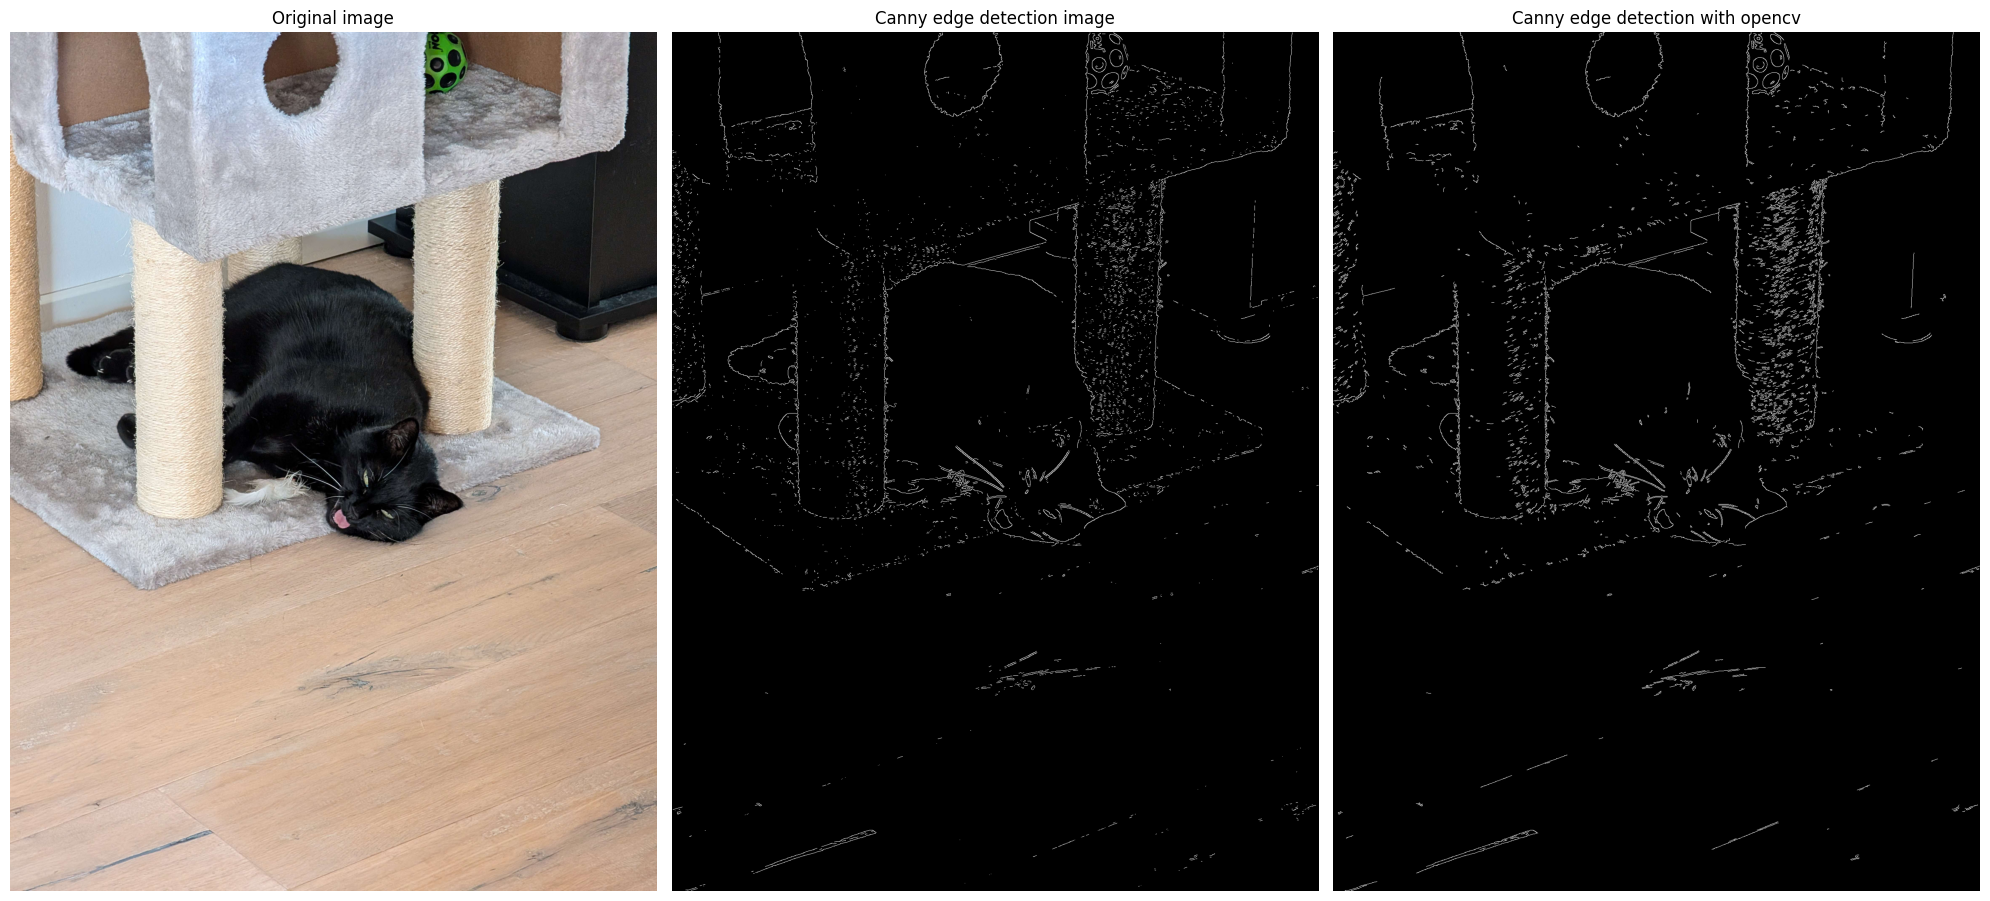

In [41]:
# Set upper and lower threshold
upper = 50 #G.max() * 0.23
lower = 100 #G.max() * 0.15

# Discard all pixels bellow the lower treshold and define strong and weak edges
tresholded_img = np.copy(non_max_img)
tresholded_img[tresholded_img < lower] = 0
tresholded_img[tresholded_img >= upper] = 255
tresholded_img[(tresholded_img >= lower) & (tresholded_img < upper)] = 50

# Edge tracking by hysteresis 
# If a weak pixel is connected to a strong one, we define it as strong as well

canny_image = np.copy(tresholded_img)
# All neighboors of a pixel
neighbors = [(-1, -1), (-1, 0), (-1, 1),
                ( 0, -1),          ( 0, 1),
                ( 1, -1), ( 1, 0), ( 1, 1)]

queue = deque(zip(*np.where(canny_image == 255))) #initialize  queue with all starting points
h, w = canny_image.shape

while queue:
    y, x = queue.popleft()
    for dy, dx in neighbors:
        ny, nx = y + dy, x + dx 
        if 0 <= ny < h and 0 <= nx < w: # check if the neighbor is within the image bounds
            if canny_image[ny, nx] == 50: # if neigbhbor is weak edge ads it to strong edges and add it to queue
                canny_image[ny, nx] = 255
                queue.append((ny, nx))

#delete left over weak edges
canny_image[canny_image != 255] = 0

fig, (im1, im2, im3) = plt.subplots(1, 3, figsize = (20, 20))

im1.imshow(imageRGB)
im1.set_title("Original image")
im1.axis("off")

im2.imshow(canny_image, cmap = "gray")
im2.set_title("Canny edge detection image") 
im2.axis("off")

cv2_canny = cv2.Canny(processed_img, 150, 290)

im3.imshow(cv2_canny, cmap = "gray")
im3.set_title("Canny edge detection with opencv") 
im3.axis("off")

plt.tight_layout()
plt.show() 

### References

[1] OpenCV. (n.d.). *Canny Edge Detection*. OpenCV Documentation. Retrieved April 1, 2025, from https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

[2] Fisher, R. B. (n.d.). *Canny Edge Detection*. HIPR2 - Image Processing Learning Resources. Retrieved April 1, 2025, from https://homepages.inf.ed.ac.uk/rbf/HIPR2/canny.htm

[3] Liang, J. (n.d.). *Canny Edge Detection*. Retrieved April 1, 2025, from https://justin-liang.com/tutorials/canny/